<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/movie-recommendations/MovieRecommendationsUsingTwoTowerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scann

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dot, Flatten, IntegerLookup, Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
from keras import regularizers
import tensorflow_datasets as tfds
from keras import initializers
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import io
import scann

# Download the MovieLens full dataset

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

path_to_downloaded_file = tf.keras.utils.get_file("ml-latest.zip", url, extract=True)
print(path_to_downloaded_file)
dataset_dir = os.path.join(os.path.dirname(path_to_downloaded_file), 'ml-latest')
print(dataset_dir)
ratings_dir = os.path.join(dataset_dir, "ratings.csv")
movies_dir = os.path.join(dataset_dir, "movies.csv")

350896731/350896731 [==============================] - 12s 0us/step
/root/.keras/datasets/ml-latest.zip
/root/.keras/datasets/ml-latest


# Transform the movie dataset
Examine the movies dataset. It seems the movie ids are not continuous numbers, but sparse integers. We will map them to new ids using integer_lookup into a new set of ids to use in the embedding matrix.

In [ ]:
import pandas as pd
df_movies = pd.read_csv(movies_dir)
integer_lookup = IntegerLookup(name="movieId Lookup")
integer_lookup.adapt(df_movies["movieId"])
df_movies["movieIdDense"] = integer_lookup(df_movies["movieId"])
df_movies

,movieId,title,genres,movieIdDense
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,86537
1,2,Jumanji (1995),Adventure|Children|Fantasy,86536
2,3,Grumpier Old Men (1995),Comedy|Romance,86535
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,86534
4,5,Father of the Bride Part II (1995),Comedy,86533
...,...,...,...,...
86532,288967,State of Siege: Temple Attack (2021),Action|Drama,5
86533,288971,Ouija Japan (2021),Action|Horror,4
86534,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,3
86535,288977,Skinford: Death Sentence (2023),Crime|Thriller,2


In [ ]:
df_movies["title"][1]

'Jumanji (1995)'

# Look at the ratings dataset
We will add the same dense movie id that we created earlier to this so that we can use these during training.

In [ ]:
df_ratings = pd.read_csv(ratings_dir)
df_ratings["movieIdDense"] = integer_lookup(df_ratings["movieId"])
df_ratings

,userId,movieId,rating,timestamp,movieIdDense
0,1,1,4.0,1225734739,86537
1,1,110,4.0,1225865086,86429
2,1,158,4.0,1225733503,86381
3,1,260,4.5,1225735204,86280
4,1,356,5.0,1225735119,86186
...,...,...,...,...,...
33832157,330975,8340,2.0,1091583256,78804
33832158,330975,8493,2.5,1091585709,78714
33832159,330975,8622,4.0,1091581777,78626
33832160,330975,8665,3.0,1091581765,78583


In [ ]:
NUM_RATINGS = df_ratings["userId"].size
NUM_USERS=df_ratings["userId"].nunique()
NUM_MIN_USER_ID = df_ratings["userId"].min()
NUM_MAX_USER_ID = df_ratings["userId"].max()

NUM_MOVIES = df_movies["movieId"].nunique()
NUM_MIN_MOVIE_ID = df_movies["movieId"].min()
NUM_MAX_MOVIE_ID = df_movies["movieId"].max()
ALL_MOVIE_IDS = df_movies['movieIdDense'].unique()

# Build and train the model

In [ ]:
train, test = train_test_split(df_ratings, test_size=0.2)
ROW_COUNT = train.shape[0]
train.head()

,userId,movieId,rating,timestamp,movieIdDense
19095378,187153,1273,3.0,1109982155,85297
12383621,121751,3408,5.0,1518630038,83223
1930893,18931,99351,2.0,1670179068,67467
6077176,59173,4387,2.0,1127376870,82254
26253832,256257,588,4.0,839587226,85957


In [ ]:
def build_model(num_users, num_movies, embedding_dim):
  movie_input = Input(shape=(1,), name="movie_id")
  movie_emb = Embedding(input_dim=num_movies+1, output_dim=embedding_dim,
                        name='movie_emb')(movie_input)
  movie_vec = Flatten(name='flatten_movie')(movie_emb)
  movie_model = Model(inputs=movie_input, outputs=movie_vec)


  user_input = Input(shape=(1,), name="user_id")
  user_emb = Embedding(input_dim=num_users+1, output_dim=embedding_dim,
                      name='user_emb')(user_input)
  user_vec = Flatten(name='flatten_user')(user_emb)
  user_model = Model(inputs=user_input, outputs=user_vec)

  x = Dot(name = 'dot_product', normalize=True, axes=2)([movie_emb, user_emb])
  x = Dense(70, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(10, activation='relu')(x)
  result = Dense(1, activation=None)(x)
  model = Model([movie_input, user_input], result)
  return model, movie_model, user_model

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 movie_emb (Embedding)       (None, 1, 20)                1730760   ['movie_id[0][0]']            
                                                                                                  
 user_emb (Embedding)        (None, 1, 20)                6619520   ['user_id[0][0]']             
                                                                                            

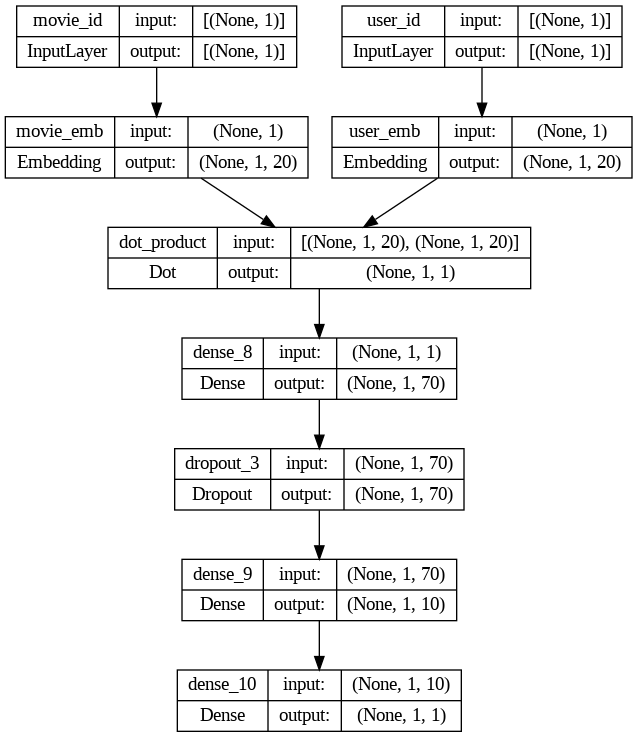

In [ ]:
# Embedding dimension should be around the 4th root of vacab (~86000 movies)
EMBEDDING_DIM = 20
model, movie_model, user_model = build_model(NUM_USERS, NUM_MOVIES, EMBEDDING_DIM)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='mean_absolute_error')
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=10)]

history = model.fit([train.movieIdDense, train.userId],train.rating, batch_size=100000,
                              epochs=50, validation_data = ([test.movieIdDense, test.userId],test.rating),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/50
271/271 [==============================] - 30s 103ms/step - loss: 1.3771 - val_loss: 0.7761
Epoch 2/50
271/271 [==============================] - 27s 100ms/step - loss: 0.7388 - val_loss: 0.6773
Epoch 3/50
271/271 [==============================] - 27s 100ms/step - loss: 0.6778 - val_loss: 0.6553
Epoch 4/50
271/271 [==============================] - 27s 100ms/step - loss: 0.6466 - val_loss: 0.6410
Epoch 5/50
271/271 [==============================] - 27s 100ms/step - loss: 0.6245 - val_loss: 0.6322
Epoch 6/50
271/271 [==============================] - 27s 99ms/step - loss: 0.6080 - val_loss: 0.6271
Epoch 7/50
271/271 [==============================] - 27s 99ms/step - loss: 0.5945 - val_loss: 0.6241
Epoch 8/50
271/271 [==============================] - 27s 100ms/step - loss: 0.5831 - val_loss: 0.6217
Epoch 9/50
271/271 [==============================] - 27s 100ms/step - loss: 0.5726 - val_loss: 0.6199
Epoch 10/50
271/271 [==============================] - 27s 100ms/step - los

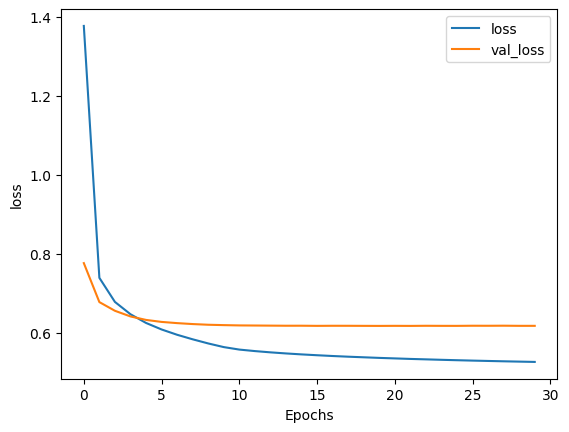

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()


plot_graphs(history, "loss")

# Movie Similarties
Our model has learnt tbe embeddings for users and movies in the same embedding space. We can now use these embeddings to find movies similar to other movies

In [ ]:
movie_embeddings = movie_model.predict(np.array(ALL_MOVIE_IDS))
k = int(np.sqrt(movie_embeddings.shape[0]))
searcher = scann.scann_ops_pybind.builder(movie_embeddings, 10, "dot_product").tree(
    num_leaves=k, num_leaves_to_search=int(k/20), training_sample_size=k).score_brute_force(2).reorder(7).build()

def get_related_movies(id, movie_embeddings):
  query_vector = movie_embeddings[id]
  results = searcher.search(query_vector)
  return results[0]

def get_related_movies_df(movie_list):
  movies = []
  for movie_row_id in movie_list:
    related_movies = []
    related_movies.append(df_movies["title"][movie_row_id])
    related_movie_ids = get_related_movies(movie_row_id, movie_embeddings)
    for related_movie_id in related_movie_ids:
      related_movies.append(df_movies["title"][related_movie_id])
    movies.append(related_movies)
  df = pd.DataFrame(movies).transpose()
  return df

2705/2705 [==============================] - 3s 981us/step


In [ ]:
# Toy Story (1995), Live and Let Die (1973), For a Few Dollars More, Tora! Tora! Tora! (1970), Memento (2000)
# Generate movies similar to the above four movies.
movie_list = [0, 2899, 3581, 3882, 4123]
df = get_related_movies_df(movie_list)
df

,0,1,2,3,4
0,Toy Story (1995),Live and Let Die (1973),For a Few Dollars More (Per qualche dollaro in...,"Eagle Has Landed, The (1976)",Memento (2000)
1,Toy Story 2 (1999),"Man with the Golden Gun, The (1974)","Fistful of Dollars, A (Per un pugno di dollari...","Eagle Has Landed, The (1976)",Memento (2000)
2,Toy Story (1995),Never Say Never Again (1983),For a Few Dollars More (Per qualche dollaro in...,"Last of the Mohicans, The (1992)",Open Your Eyes (Abre los ojos) (1997)
3,Toy Story 3 (2010),"Spy Who Loved Me, The (1977)",Pale Rider (1985),Frailty (2001),"Das Experiment (Experiment, The) (2001)"
4,"Monsters, Inc. (2001)",Diamonds Are Forever (1971),High Plains Drifter (1973),"Bounty, The (1984)",Run Lola Run (Lola rennt) (1998)
5,"Incredibles, The (2004)",You Only Live Twice (1967),"Getaway, The (1972)",Brainstorm (1983),A Second Chance (2014)
6,Finding Nemo (2003),Live and Let Die (1973),"Outlaw Josey Wales, The (1976)",Brubaker (1980),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
7,Ratatouille (2007),For Your Eyes Only (1981),Hang 'Em High (1968),Tora! Tora! Tora! (1970),High Fidelity (2000)
8,"Bug's Life, A (1998)",Dr. No (1962),"Magnificent Seven, The (1960)",Three O'Clock High (1987),American Beauty (1999)
9,Up (2009),Octopussy (1983),"Dirty Dozen, The (1967)",Silver Streak (1976),Shallow Grave (1994)


# Movie recommendations for a user
We can now get the embeddings for a user and recommend movies close to the user in the embeding space.

In [ ]:
# Print a user embedding
def recommend_movies(user_id):
  user_vector = user_model.predict([np.array([user_id])])[0]
  results = searcher.search(user_vector)
  for related_movie_id in results[0]:
    print(df_movies["title"][related_movie_id])
recommend_movies(610)

1/1 [==============================] - 0s 37ms/step
Taco Shop
How We Lookin'? (2020)
Frank Blue (2018)
Semper Fi: Always Faithful (2011)
Jack Reed: A Search for Justice (1994)
Lena (2021)
Problem Child: Leslie Jones (2010)
2 Jennifer (2016)
Her Majesty (2001)
The Chaos Class Welcome (2004)


# Generate vector and metadata files for embedding visualization of the movies

In [ ]:
# Generate files for embedding visualization
movie_embeddings = movie_model.predict(np.array(ALL_MOVIE_IDS))
embedding_columns = ['e'+str(i) for i in range(EMBEDDING_DIM)]
df_movie_embedding = pd.DataFrame(
    movie_embeddings,
    columns=embedding_columns)
result = pd.concat([df_movies, df_movie_embedding], axis=1)

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for index, row in result.iterrows():
  row_embeddings = [str(row[col_name]) for col_name in embedding_columns]
  out_m.write(row['title'] + "\n")
  out_v.write('\t'.join(row_embeddings) + '\n')

out_v.close()
out_m.close()

2705/2705 [==============================] - 2s 829us/step



#Use the vectors downloaded to look at the embeddings of movies and their nearest neighbors


![picture](https://drive.usercontent.google.com/download?id=10-wG3TImG7yb-RogAG3J6MgqfXrV4IMK)



